#  Survival Analysis on Telco Customer Churn

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
#from scipy.stats import chi2
from scipy.stats import chi2_contingency

from scipy.stats import t
from scipy.stats import ttest_ind
import scipy.stats as ss


from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from sksurv.compare import compare_survival
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator 
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.svm import FastKernelSurvivalSVM

from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

from sksurv.util import Surv

import seaborn as sns 
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [44]:
df = pd.read_csv('/Data Science/DSC/Capstone Project 1/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Wrangling

In [72]:
# Check the size of dataframe 

In [45]:
df.shape 

(7043, 21)

In [421]:
#view the first five rows 

In [46]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [422]:
# the detailed info of the first row, so that we have a basic understanding about how does the data format looks like

In [47]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

In [ ]:
#check the datatype of each feature

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [49]:
# check missing values, it looks likr no missing value but we we will look into further 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data Types Transformation

In [50]:
# The feature SeniorCitizen indicates whether the customer is a senior citizen or not (1, 0)
# so we need to convert it into catogorical type 
# The feature TotalCharges indicates the total amount charged to the customer
# so we nned to convert it into numerical type 
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['TotalCharges_num'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [399]:
# double check the data types have been successfully converted 

In [51]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

In [429]:
# Check the descriptive statistics for numerical features
# However, the converted TotalCharges generate 11 missing values 
# which means the origical TotalCharges has some invaid values, even though they appear non-missing values 

In [52]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [ ]:
# check missling values again 

In [53]:
for col in df.columns:
    print(col,df[col].isnull().sum())

customerID 0
gender 0
SeniorCitizen 0
Partner 0
Dependents 0
tenure 0
PhoneService 0
MultipleLines 0
InternetService 0
OnlineSecurity 0
OnlineBackup 0
DeviceProtection 0
TechSupport 0
StreamingTV 0
StreamingMovies 0
Contract 0
PaperlessBilling 0
PaymentMethod 0
MonthlyCharges 0
TotalCharges 0
Churn 0
TotalCharges_num 11


## Missing Data Imputation

In [432]:
# I discovered that there are 11 observations whose TotalCahrges is string of spaces( missing data)
# we impute them with 0 

In [54]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [55]:
df[df['TotalCharges_num'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [ ]:
# Impute the missing data on TotalCharges_num

In [56]:
df.loc[df['TotalCharges_num'].isnull(),'TotalCharges_num']  = 0

In [57]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,0.0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,0.0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,0.0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,0.0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,0.0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,0.0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,0.0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,0.0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,0.0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,0.0


In [58]:
# The feature TotalCharges_num's missing values have been imputed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null category
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
TotalCharges_num    7043 non-n

In [59]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [60]:
# check the distribution of target variable 
df.Churn.value_counts()/len(df)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

# Exploratory Data Analysis (EDA)
Q: **What is the distribution of those three numerical variables? How would you explain them?**

A: The distribution of total charges is very positively skewed. The majority of customers are charged under \$2000.

   As for the distribution of monthly charges, above \$30 and beyond, it distributes nearly normal. 
   However low-end customers with less than \\$30 accounts for a large portion. 
   
   Even though the distribution of TotalCharges is postively skewed and the distribution of MonthlyCharges 
   has a great number of observations in the low of monthly charges (not distributed normally), I wouldn't 
   treat them as outliers according the business sense, since we will apply survival analysis in this case
   
   The distribution of tenure shows a relatively stable trend between 10 months and 60 months. However, significant
   number of customers stayed with business below 10 months(new customers)  or above 60 months(loyal cutomers).


Text(0, 0.5, 'Number of Customers')

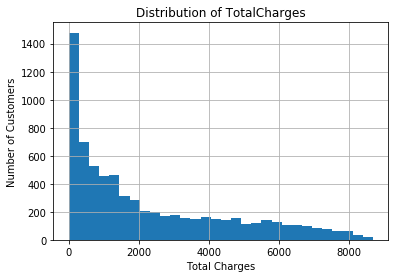

In [61]:
fig = df.TotalCharges_num.hist(bins=30)
fig.set_title('Distribution of TotalCharges')
fig.set_xlabel('Total Charges')
fig.set_ylabel('Number of Customers')

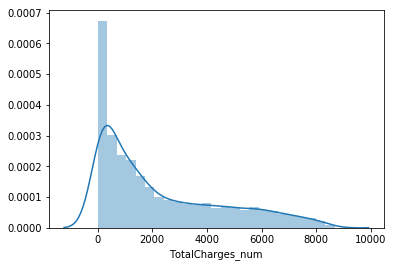

In [62]:
sns.distplot(df.TotalCharges_num)

Text(0, 0.5, 'Number of Customers')

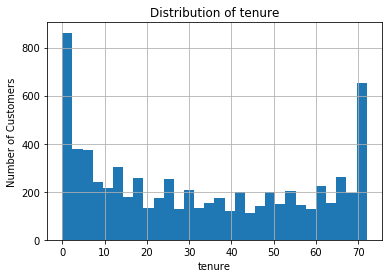

In [63]:
fig = df.tenure.hist(bins=30)
fig.set_title('Distribution of tenure')
fig.set_xlabel('tenure')
fig.set_ylabel('Number of Customers')

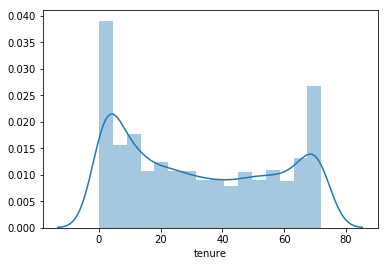

In [64]:
sns.distplot(df.tenure)

Text(0, 0.5, 'Number of Customers')

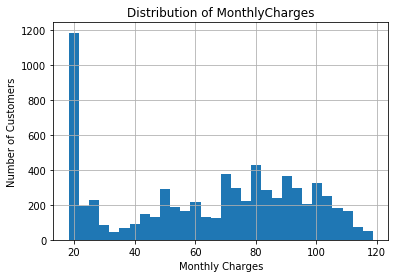

In [65]:
fig = df.MonthlyCharges.hist(bins=30)
fig.set_title('Distribution of MonthlyCharges')
fig.set_xlabel('Monthly Charges')
fig.set_ylabel('Number of Customers')

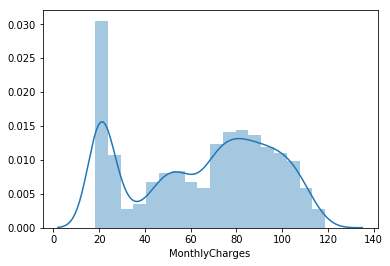

In [66]:
sns.distplot(df.MonthlyCharges)

In [27]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

**Q: What is the distribution of those categorical variables? How would you explain them?**

A: From a business perspective, we ignore the first feature customerID.
   For all other categorical feature,  the largest number of different labels is 4. So the cardinality is not high, so    that it is not likely cause overfitting 
   And the relatively rare labels is 9% for 'NO' values of Phoneservice 9% for 'No phone service' of MultipleLines
   this also is unlikely to cause overfitting

In [67]:

categorical_col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                   'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']
numerical_col = ['tenure','MonthlyCharges','TotalCharges_num']
for col in categorical_col:
    print(col)
    print(df[col].value_counts()/len(df))
    print('------------------------')

gender
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
------------------------
SeniorCitizen
0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64
------------------------
Partner
No     0.516967
Yes    0.483033
Name: Partner, dtype: float64
------------------------
Dependents
No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64
------------------------
PhoneService
Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64
------------------------
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64
------------------------
InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64
------------------------
OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64
------------------------
OnlineBacku

In [27]:
#col = categorical_col[15]
#plt.pie(df[col].value_counts(), autopct='%1.1f%%',textprops={'fontsize': 18},labels=df[col].value_counts().index)
#plt.title(col,fontsize=24)

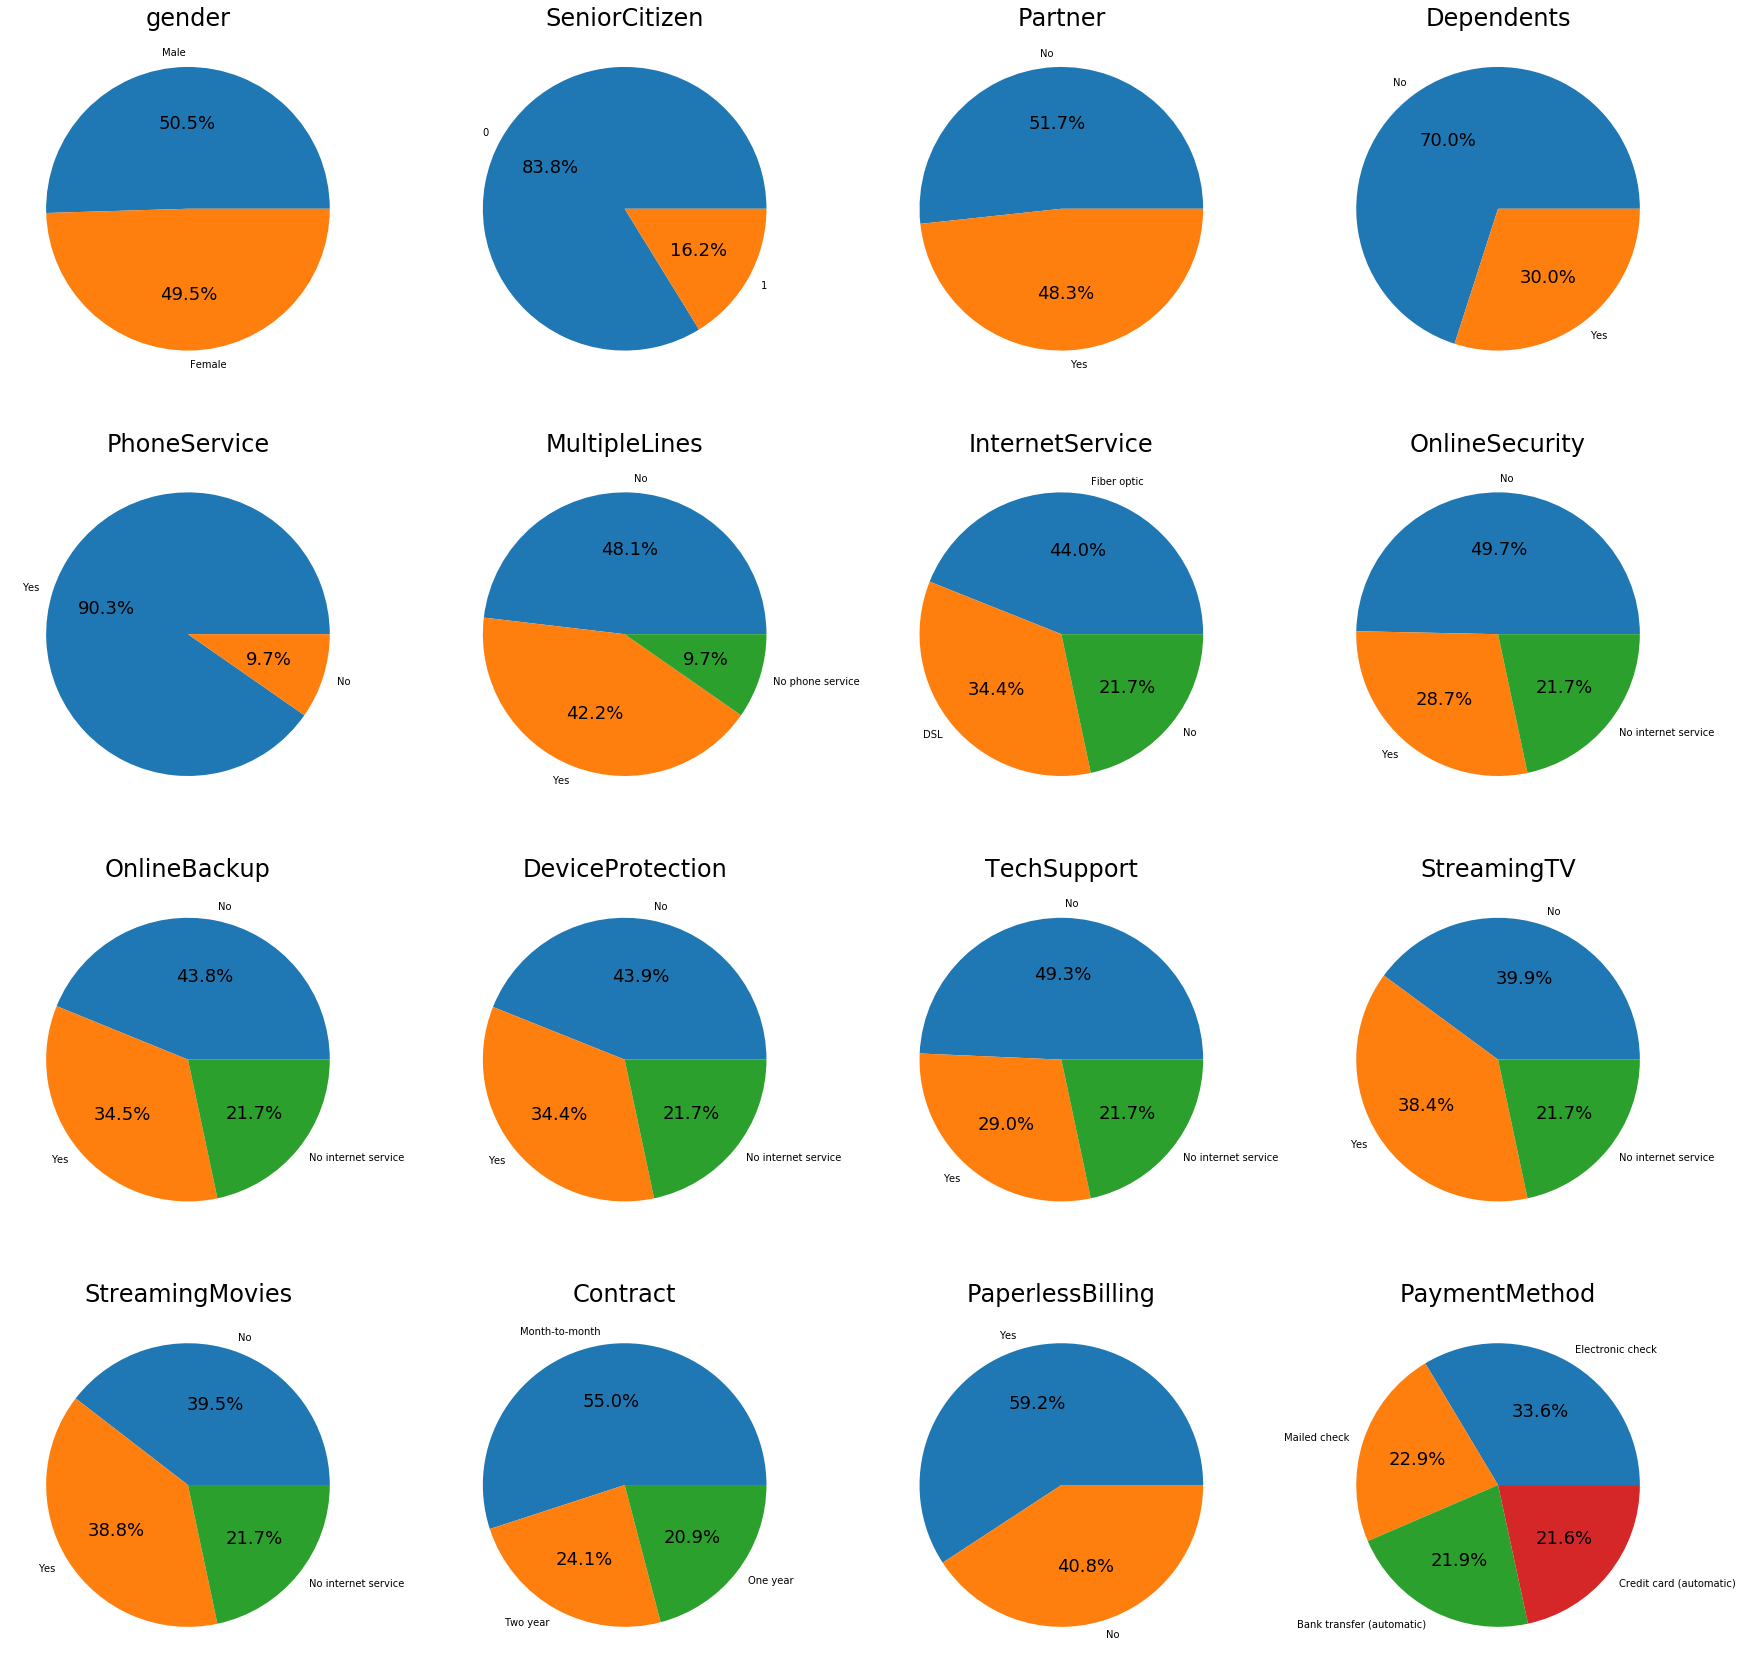

In [68]:
fig, axs = plt.subplots(4,4,figsize=(30,30))
for i, ax in enumerate(axs.reshape(-1)):
    col = categorical_col[i]
    ax.pie(df[col].value_counts(), autopct='%1.1f%%',textprops={'fontsize': 18},labels=df[col].value_counts().index)
    ax.set_title(col,fontsize=24)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null category
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
TotalCharges_num    7043 non-n

# Statistical Data Analysis

## Frequentist Inference
**Q: If we divide all observations into two groups: churned and not-churned. How does the numerical variables's mean 
   differ between both groups? How would you explaing them statistically?**
   
A: The result of t-test indicates that statistically significance does exist since p-values are all extremely low. So we can confidenty reject the null hypothere and conclude that all these numerical variables differs between two groups. Please also be noteed that these three variables were considered individually.  
   For this particular project, we are going to perform survival analysis, we should treat variable 'tenure' as time factor that may bring censoring issue.  This will be addressed in model building and model performance evaluation that follows.
   
### t-test for MonthlyCharges, Totalcharges and tenure 

In [70]:
group0 = df[df['Churn'] == 'No']['MonthlyCharges']
group1 = df[df['Churn'] == 'Yes']['MonthlyCharges']

print('the mean of MonthlyCharge for not churned: ',np.mean(group0))
print('the mean of MonthlyCharge for churned: ', np.mean(group1))

ttest_ind(group0,group1)

the mean of MonthlyCharge for not churned:  61.2651236953999
the mean of MonthlyCharge for churned:  74.4413322632423


Ttest_indResult(statistic=-16.53673801593631, pvalue=2.706645606888261e-60)

In [71]:
group0 = df[df['Churn'] == 'No']['TotalCharges_num']
group1 = df[df['Churn'] == 'Yes']['TotalCharges_num']

print('the mean of TotalCharges for not churned: ',np.mean(group0))
print('the mean of TotalCharges for churned: ', np.mean(group1))

ttest_ind(group0,group1)


the mean of TotalCharges for not churned:  2549.911441824514
the mean of TotalCharges for churned:  1531.7960941680035


Ttest_indResult(statistic=16.978779727124437, pvalue=2.127211613240394e-63)

In [72]:
group0 = df[df['Churn'] == 'No']['tenure']
group1 = df[df['Churn'] == 'Yes']['tenure']

print('the mean of tenure for not churned: ',np.mean(group0))
print('the mean of tenure for churned: ', np.mean(group1))

ttest_ind(group0,group1)

the mean of tenure for not churned:  37.56996521066873
the mean of tenure for churned:  17.979133226324237


Ttest_indResult(statistic=31.57955051135377, pvalue=7.99905796059022e-205)

**Q: Since the majority of the features are categorical,after we had an idea about cardinality, we are more interested in how each labeled groups affect the  performance of time-event in the context of survival analysis.**

A: Rather than using traditional chi-square contigence table, we use Log rank test together with Kaplan-Meier curve to figue out how those groups differ from each other. 
   The diagram below indicates that out the 16 categorical variables, only "gender" and 'PhoneService" have large value of p-values. We don't have sufficient evidence to reject null hypothesis for them. 

## Log rank test for all categorical variables 

<lifelines.StatisticalResult>
 null_distribution = chi squared
               t_0 = -1
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          0.53 0.47      1.09


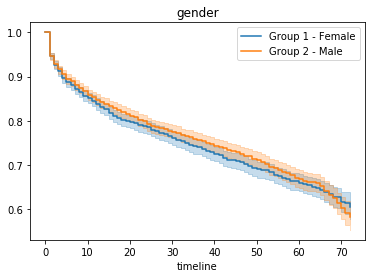

In [74]:
# for 'gender'
group1 = df[df['gender'] == 'Female']
group2 = df[df['gender'] == 'Male']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Female").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Male").plot(ax=ax)
ax.set_title('gender')

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic      p  -log2(p)
        109.49 <0.005     82.71


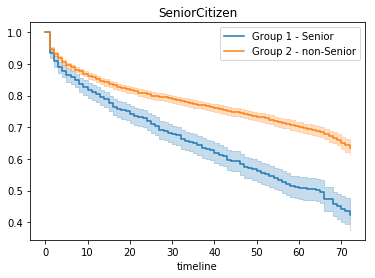

In [92]:
# SeniorCitizen
group1 = df[df['SeniorCitizen'] == 1]
group2 = df[df['SeniorCitizen'] == 0]
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Senior").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Senior").plot(ax=ax)
ax.set_title('SeniorCitizen')

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()


<lifelines.StatisticalResult>
degrees_of_freedom = 1
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        423.54 <0.005    310.21


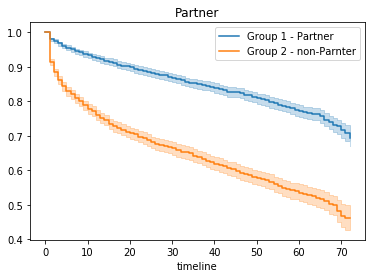

In [513]:
# Partner
group1 = df[df['Partner'] == 'Yes']
group2 = df[df['Partner'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Partner").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Parnter").plot(ax=ax)
ax.set_title('Partner')

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic      p  -log2(p)
        232.70 <0.005    172.12


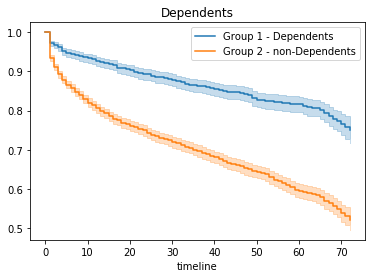

In [93]:
#Dependents        
group1 = df[df['Dependents'] == 'Yes']
group2 = df[df['Dependents'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Dependents").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Dependents").plot(ax=ax)
ax.set_title('Dependents')

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()        


<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic    p  -log2(p)
          0.43 0.51      0.97


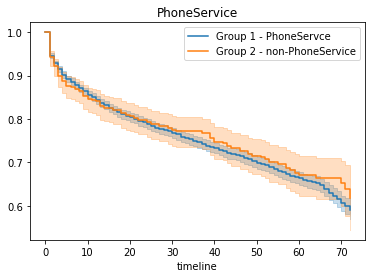

In [94]:
# PhoneService
group1 = df[df['PhoneService'] == 'Yes']
group2 = df[df['PhoneService'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - PhoneServce").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-PhoneService").plot(ax=ax)
ax.set_title('PhoneService')

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()        

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic      p  -log2(p)
        805.49 <0.005    581.04


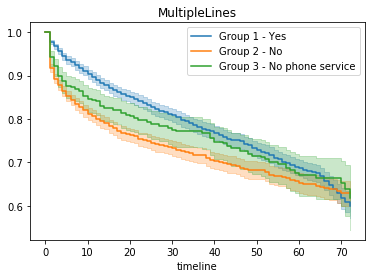

In [95]:
#MultipleLines


group1 = df[df['MultipleLines'] == 'Yes']
group2 = df[df['MultipleLines'] == 'No']
group3 = df[df['MultipleLines'] == 'No phone service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Yes").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - No").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No phone service").plot(ax=ax)
ax.set_title('MultipleLines')

result = multivariate_logrank_test(df['tenure'], df['MultipleLines'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
#esults=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
#results.print_summary() 

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic    p  -log2(p)
          9.15 0.01      6.60


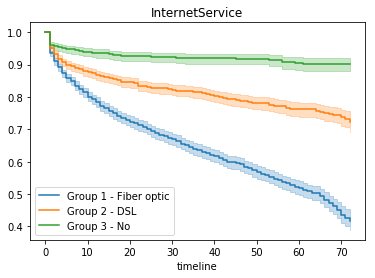

In [100]:
#InternetService

group1 = df[df['InternetService'] == 'Fiber optic']
group2 = df[df['InternetService'] == 'DSL']
group3 = df[df['InternetService'] == 'No']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Fiber optic").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - DSL").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No").plot(ax=ax)
ax.set_title('InternetService')


result = multivariate_logrank_test(df['tenure'], df['InternetService'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
        


<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic      p  -log2(p)
        731.48 <0.005    527.65


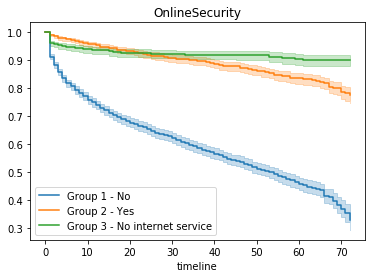

In [106]:
#OnlineSecurity


group1 = df[df['OnlineSecurity'] == 'No']
group2 = df[df['OnlineSecurity'] == 'Yes']
group3 = df[df['OnlineSecurity'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('OnlineSecurity')


result = multivariate_logrank_test(df['tenure'], df['OnlineSecurity'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
        


<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic      p  -log2(p)
        938.01 <0.005    676.63


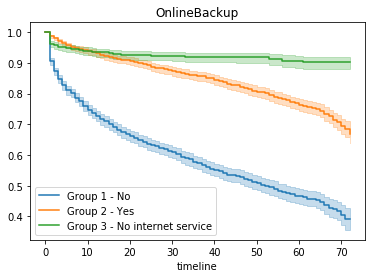

In [107]:
#OnlineBackup

group1 = df[df['OnlineBackup'] == 'No']
group2 = df[df['OnlineBackup'] == 'Yes']
group3 = df[df['OnlineBackup'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('OnlineBackup')

result = multivariate_logrank_test(df['tenure'], df['OnlineBackup'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()


<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        944.26 <0.005    681.14


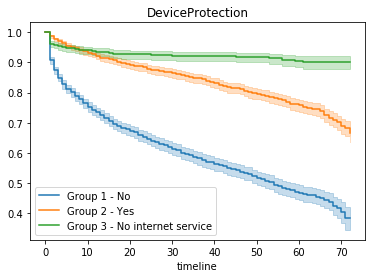

In [520]:
#DeviceProtection

        
group1 = df[df['DeviceProtection'] == 'No']
group2 = df[df['DeviceProtection'] == 'Yes']
group3 = df[df['DeviceProtection'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('DeviceProtection')


result = multivariate_logrank_test(df['tenure'], df['DeviceProtection'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()     


<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic      p  -log2(p)
        700.22 <0.005    505.10


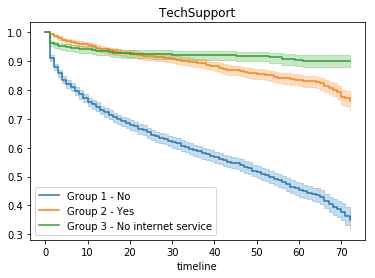

In [108]:
#TechSupport
        
group1 = df[df['TechSupport'] == 'No']
group2 = df[df['TechSupport'] == 'Yes']
group3 = df[df['TechSupport'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('TechSupport')

result = multivariate_logrank_test(df['tenure'], df['TechSupport'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 


<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        552.60 <0.005    398.62


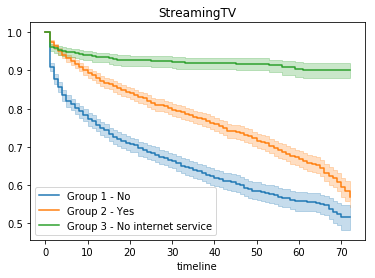

In [522]:
# StreamingTV
group1 = df[df['StreamingTV'] == 'No']
group2 = df[df['StreamingTV'] == 'Yes']
group3 = df[df['StreamingTV'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('StreamingTV')

result = multivariate_logrank_test(df['tenure'], df['StreamingTV'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 2
               t_0 = -1

---
test_statistic      p  -log2(p)
        586.98 <0.005    423.42


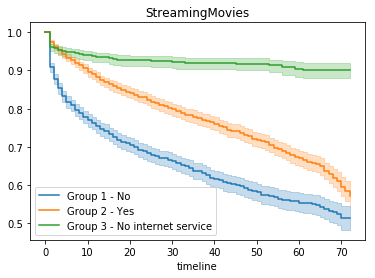

In [109]:
# StreamingMovies
group1 = df[df['StreamingMovies'] == 'No']
group2 = df[df['StreamingMovies'] == 'Yes']
group3 = df[df['StreamingMovies'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)
ax.set_title('StreamingMovies')

result = multivariate_logrank_test(df['tenure'], df['StreamingMovies'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 

<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
       3774.21 <0.005       inf


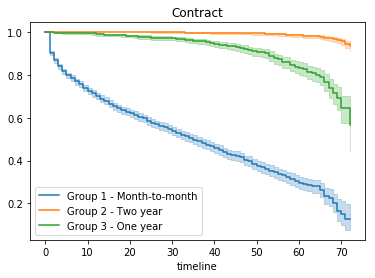

In [526]:
#Contract

        
        
group1 = df[df['Contract'] == 'Month-to-month']
group2 = df[df['Contract'] == 'Two year']
group3 = df[df['Contract'] == 'One year']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Month-to-month").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Two year").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - One year").plot(ax=ax)
ax.set_title('Contract')

result = multivariate_logrank_test(df['tenure'], df['Contract'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()      


<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic      p  -log2(p)
        189.51 <0.005    140.82


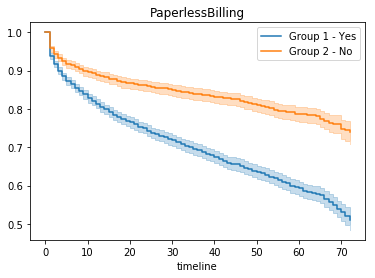

In [110]:
#PaperlessBilling

group1 = df[df['PaperlessBilling'] == 'Yes']
group2 = df[df['PaperlessBilling'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Yes").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - No").plot(ax=ax)
ax.set_title('PaperlessBilling')


results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary() 

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 3
               t_0 = -1

---
test_statistic      p  -log2(p)
       1108.40 <0.005    794.81


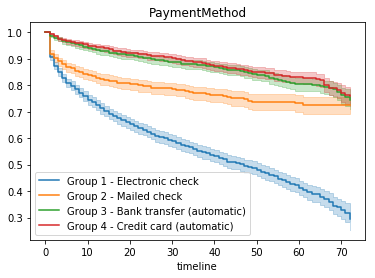

In [111]:
#PaymentMethod

        
group1 = df[df['PaymentMethod'] == 'Electronic check']
group2 = df[df['PaymentMethod'] == 'Mailed check']
group3 = df[df['PaymentMethod'] == 'Bank transfer (automatic)']
group4 = df[df['PaymentMethod'] == 'Credit card (automatic)']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)
T3 = group4['tenure']
E3 = np.where(group4['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Electronic check").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Mailed check").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - Bank transfer (automatic)").plot(ax=ax)
ax = kmf.fit(T3, E3, label="Group 4 - Credit card (automatic)").plot(ax=ax)
ax.set_title('PaymentMethod')


result = multivariate_logrank_test(df['tenure'], df['PaymentMethod'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 



## Use Cramer'V to explore correlation for categorical variables

In [101]:
# define the function to calculate the correlation index 
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [102]:
# Create and initialize the dataframe to stro
df_cramers_v = pd.DataFrame(columns=categorical_col,index = categorical_col)
df_cramers_v.loc[:,:]=0

In [103]:
# assign the value to dataframe 
for i in categorical_col:
    for j in categorical_col:
        df_cramers_v.loc[i,j] = cramers_v(df[i],df[j])       

In [105]:
df_cramers_v

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
gender,0.999716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,0.999477,0.010817,0.210442,0.000000,0.145682,0.264807,0.210411,0.182008,0.182307,0.223432,0.184832,0.188222,0.142888,0.155693,0.194908
Partner,0.000000,0.010817,0.999716,0.452241,0.012439,0.142918,0.000000,0.151083,0.152419,0.165725,0.126533,0.136314,0.128482,0.295580,0.008414,0.161460
Dependents,0.000000,0.210442,0.452241,0.999662,0.000000,0.018594,0.179491,0.193862,0.161897,0.156677,0.181610,0.146124,0.140337,0.243647,0.110429,0.149335
PhoneService,0.000000,0.000000,0.012439,0.000000,0.999188,0.999929,0.452144,0.175477,0.172007,0.171504,0.176185,0.179658,0.176731,0.000000,0.010702,0.000000
MultipleLines,0.000000,0.145682,0.142918,0.018594,0.999929,1.000000,0.396424,0.229022,0.244617,0.245800,0.229577,0.261286,0.261852,0.078633,0.165496,0.165672
InternetService,0.000000,0.264807,0.000000,0.179491,0.452144,0.396424,1.000000,0.724373,0.707084,0.707007,0.722811,0.717003,0.715911,0.206263,0.378079,0.312486
OnlineSecurity,0.002416,0.210411,0.151083,0.193862,0.175477,0.229022,0.724373,1.000000,0.718339,0.717195,0.732982,0.707688,0.708108,0.300920,0.341408,0.304303
OnlineBackup,0.000000,0.182008,0.152419,0.161897,0.172007,0.244617,0.707084,0.718339,1.000000,0.719030,0.719739,0.714602,0.713584,0.258059,0.320626,0.281802
DeviceProtection,0.000000,0.182307,0.165725,0.156677,0.171504,0.245800,0.707007,0.717195,0.719030,1.000000,0.726393,0.733572,0.735959,0.296540,0.321212,0.286319


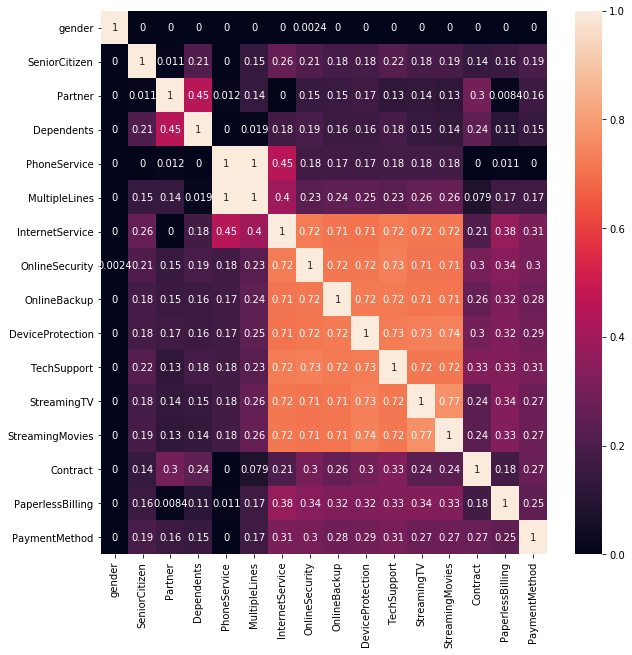

In [107]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cramers_v,annot=True)

# Model Building
## Kaplan Meier Estimator

In [108]:
# use scikit-survival  KM estimator
event = np.where(df['Churn'] == 'Yes',True,False)
time,survival_prob = kaplan_meier_estimator(event,df['tenure'])

Text(0.5, 1.0, 'Kaplan Meier Curve')

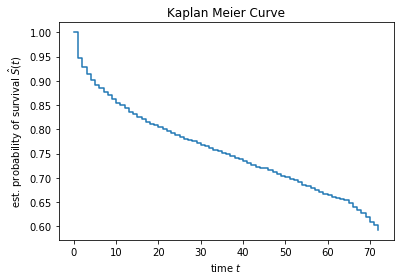

In [109]:
# Plot Kaplan Meier curve
plt.step(time,survival_prob,where = 'post')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Kaplan Meier Curve')

In [110]:
# create independent variable list without 'tenure'
# "tenure" will be combined with "churn" to produce time-event pair
col = categorical_col + numerical_col
col.remove('tenure')
#col.remove('MonthlyCharges')
col.remove('TotalCharges_num')

In [111]:
for i in categorical_col:
    df[i] = df[i].astype('category')

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null category
SeniorCitizen       7043 non-null category
Partner             7043 non-null category
Dependents          7043 non-null category
tenure              7043 non-null int64
PhoneService        7043 non-null category
MultipleLines       7043 non-null category
InternetService     7043 non-null category
OnlineSecurity      7043 non-null category
OnlineBackup        7043 non-null category
DeviceProtection    7043 non-null category
TechSupport         7043 non-null category
StreamingTV         7043 non-null category
StreamingMovies     7043 non-null category
Contract            7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object


In [149]:
col

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

In [169]:
data_x.corr()

,gender=Male,SeniorCitizen=1,Partner=Yes,Dependents=Yes,PhoneService=Yes,MultipleLines=No phone service,MultipleLines=Yes,InternetService=Fiber optic,InternetService=No,OnlineSecurity=No internet service,...,StreamingTV=Yes,StreamingMovies=No internet service,StreamingMovies=Yes,Contract=One year,Contract=Two year,PaperlessBilling=Yes,PaymentMethod=Credit card (automatic),PaymentMethod=Electronic check,PaymentMethod=Mailed check,MonthlyCharges
gender=Male,1.000000,-0.001874,-0.001808,0.010517,-0.006488,0.006488,-0.008414,-0.011286,0.006026,0.006026,...,-0.008393,0.006026,-0.010487,0.008026,-0.003695,-0.011754,0.001215,0.000752,0.013744,-0.014569
SeniorCitizen=1,-0.001874,1.000000,0.016479,-0.211185,0.008576,-0.008576,0.142948,0.255338,-0.182742,-0.182742,...,0.105378,-0.182742,0.120176,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477,0.220173
Partner=Yes,-0.001808,0.016479,1.000000,0.452676,0.017706,-0.017706,0.142057,0.000304,0.000615,0.000615,...,0.124666,0.000615,0.117412,0.082783,0.248091,-0.014877,0.082029,-0.083852,-0.095125,0.096848
Dependents=Yes,0.010517,-0.211185,0.452676,1.000000,-0.001762,0.001762,-0.024526,-0.165818,0.139812,0.139812,...,-0.016558,0.139812,-0.039741,0.068368,0.204613,-0.111377,0.060267,-0.150642,0.059071,-0.113890
PhoneService=Yes,-0.006488,0.008576,0.017706,-0.001762,1.000000,-1.000000,0.279690,0.289999,0.172209,0.172209,...,-0.022574,0.172209,-0.032959,-0.002791,0.003519,0.016505,-0.007721,0.003062,-0.003319,0.247398
MultipleLines=No phone service,0.006488,-0.008576,-0.017706,0.001762,-1.000000,1.000000,-0.279690,-0.289999,-0.172209,-0.172209,...,0.022574,-0.172209,0.032959,0.002791,-0.003519,-0.016505,0.007721,-0.003062,0.003319,-0.247398
MultipleLines=Yes,-0.008414,0.142948,0.142057,-0.024526,0.279690,-0.279690,1.000000,0.366083,-0.210564,-0.210564,...,0.257152,-0.210564,0.258751,-0.003794,0.106253,0.163530,0.060048,0.083618,-0.227206,0.490434
InternetService=Fiber optic,-0.011286,0.255338,0.000304,-0.165818,0.289999,-0.289999,0.366083,1.000000,-0.465793,-0.465793,...,0.329349,-0.465793,0.322923,-0.076324,-0.211526,0.326853,-0.050077,0.336410,-0.306834,0.787066
InternetService=No,0.006026,-0.182742,0.000615,0.139812,0.172209,-0.172209,-0.210564,-0.465793,1.000000,1.000000,...,-0.415552,1.000000,-0.418675,0.038004,0.218278,-0.321013,0.001030,-0.284917,0.321361,-0.763557
OnlineSecurity=No internet service,0.006026,-0.182742,0.000615,0.139812,0.172209,-0.172209,-0.210564,-0.465793,1.000000,1.000000,...,-0.415552,1.000000,-0.418675,0.038004,0.218278,-0.321013,0.001030,-0.284917,0.321361,-0.763557


## Categorical Features Encoding

In [150]:
from sksurv.preprocessing import OneHotEncoder
data_x = OneHotEncoder().fit_transform(df[col])
data_x.head(10)

,gender=Male,SeniorCitizen=1,Partner=Yes,Dependents=Yes,PhoneService=Yes,MultipleLines=No phone service,MultipleLines=Yes,InternetService=Fiber optic,InternetService=No,OnlineSecurity=No internet service,...,StreamingTV=Yes,StreamingMovies=No internet service,StreamingMovies=Yes,Contract=One year,Contract=Two year,PaperlessBilling=Yes,PaymentMethod=Credit card (automatic),PaymentMethod=Electronic check,PaymentMethod=Mailed check,MonthlyCharges
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.85
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.85
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.30
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,70.70
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,99.65
6,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,89.10
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.75
8,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,104.80
9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56.15


In [151]:
# remove duplicated columns caused by the OneHotEncoding
data_x_unique = data_x.T.drop_duplicates().T
data_x_unique.head(10)

,gender=Male,SeniorCitizen=1,Partner=Yes,Dependents=Yes,PhoneService=Yes,MultipleLines=No phone service,MultipleLines=Yes,InternetService=Fiber optic,InternetService=No,OnlineSecurity=Yes,...,TechSupport=Yes,StreamingTV=Yes,StreamingMovies=Yes,Contract=One year,Contract=Two year,PaperlessBilling=Yes,PaymentMethod=Credit card (automatic),PaymentMethod=Electronic check,PaymentMethod=Mailed check,MonthlyCharges
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.85
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.85
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.30
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,70.70
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,99.65
6,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,89.10
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.75
8,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,104.80
9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56.15


In [1103]:
# standardization intergated with CoxPH as pipeline
#scaler = StandardScaler()
#data_x_unique_std = scaler.fit_transform(data_x_unique)

In [161]:
## train test split 
X_train, X_test, y_train, y_test = train_test_split(data_x_unique, df[['tenure','Churn']], 
                                                    test_size=0.25, random_state=112)

## create structured array of (churn tenure) pair for training and test dataset 

In [162]:
data_y = np.zeros(len(y_train), dtype={'names':('Churn', 'tenure'),
                          'formats':('bool' ,'f8')})
data_y['Churn'] = np.where(y_train['Churn'] =='Yes',True,False)
data_y['tenure'] = y_train['tenure']


data_y_test = np.zeros(len(y_test), dtype={'names':('Churn', 'tenure'),
                          'formats':('bool' ,'f8')})
data_y_test['Churn'] = np.where(y_test['Churn'] =='Yes',True,False)
data_y_test['tenure'] = y_test['tenure']


## Cox Proportional Hazards model

In [163]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
#estimator = CoxPHSurvivalAnalysis()
#estimator.fit(X_train,data_y)

In [164]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', CoxPHSurvivalAnalysis())])
pipe.fit(X_train,data_y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow',
                                       tol=1e-09, verbose=0))],
         verbose=False)

In [165]:
pd.Series(pipe[-1].coef_, index=data_x_unique.columns)

gender=Male                             -5.583261e-02
SeniorCitizen=1                         -1.190999e-02
Partner=Yes                             -2.513708e-01
Dependents=Yes                          -1.601617e-02
PhoneService=Yes                         2.752888e+14
MultipleLines=No phone service           2.752888e+14
MultipleLines=Yes                       -1.365140e-01
InternetService=Fiber optic              5.653674e-01
InternetService=No                      -7.814199e-01
OnlineSecurity=Yes                      -2.169676e-01
OnlineBackup=Yes                        -2.038287e-01
DeviceProtection=Yes                    -9.145061e-02
TechSupport=Yes                         -1.105452e-01
StreamingTV=Yes                          1.239562e-01
StreamingMovies=Yes                      9.589250e-02
Contract=One year                       -6.729242e-01
Contract=Two year                       -1.349048e+00
PaperlessBilling=Yes                     9.465621e-02
PaymentMethod=Credit card (a

In [114]:
#pd.Series(estimator.coef_, index=data_x_unique.columns)

No handles with labels found to put in legend.


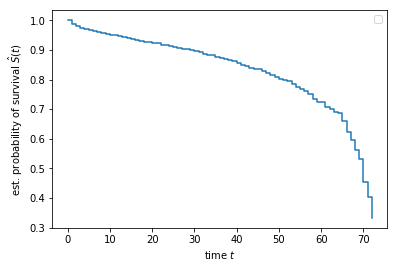

In [166]:
# Check baseline survival function 
plt.step(pipe[-1].baseline_survival_.x, pipe[-1].baseline_survival_.y, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Model Performance Evaluation

##   concordance index censored 

In [725]:
# calculate concordance_index_censored on test set
prediction = pipe.predict(X_test)
result = concordance_index_censored(np.where(y_test["Churn"]=='Yes',True,False), y_test["tenure"], prediction)
result

(0.8581643206446894, 470472, 77757, 4, 12499)

In [546]:
# the same as above 
pipe.score(X_test,data_y_test)

0.8581643206446894

In [ ]:
# calculate score on training set 

In [547]:
pipe.score(X_train,data_y)

0.8674999661869456

##  concordance_index_ipcw

In [548]:
c_uno = concordance_index_ipcw(data_y, data_y_test,prediction)
print(c_uno)

(0.8592513699250056, 470472, 77757, 4, 12499)


##  time-dependent AUC

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

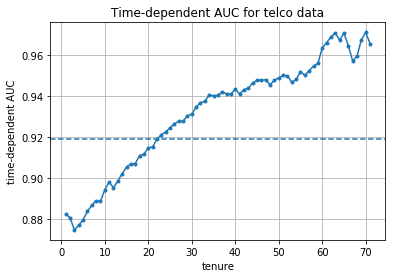

In [549]:
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, prediction, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [56]:
print(mean_auc)

0.9192194018703518


#   Feature Selection
##  L1-based feature selection using CoxnetSurvivalAnalysis 

In [551]:
# specify l1_ratio =1 to apply l1 norm
# enable data standardization   normalize = True
Cox_net = CoxnetSurvivalAnalysis(l1_ratio=1,normalize=True)
Cox_net.fit(X_train,data_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
                       fit_baseline_model=False, l1_ratio=1, max_iter=100000,
                       n_alphas=100, normalize=True, penalty_factor=None,
                       tol=1e-07, verbose=False)

In [552]:
# using alphas sequence to re-fit training data and retrive the scores(concordance_index_censored) 
score_dict = {}
for alpha in Cox_net.alphas_:
    Cox_net_alpha = CoxnetSurvivalAnalysis(alphas = [alpha],l1_ratio=1, normalize=True)
    Cox_net_alpha.fit(X_train,data_y)
    score = Cox_net_alpha.score(X_test,data_y_test)
    score_dict[alpha] = score

In [553]:
print(score_dict)

{0.0005984133115743973: 0.8359146567244219, 2.777588544888968e-05: 0.8578670018039775, 0.002415804866599759: 0.6655819697099591, 0.0022011914204882483: 0.6655819697099591, 7.728805121043603e-05: 0.8568765470155937, 0.00014823154652116407: 0.8551245547057547, 0.0016651205865272406: 0.7862459939478288, 0.00182746778811072: 0.7618731451773242, 0.0013824123639931327: 0.805651976440674, 3.345615235701001e-05: 0.8577612073698592, 0.0026513428587653528: 0.6655819697099591, 3.671808590996609e-05: 0.8576973659009947, 0.0015171958628848005: 0.7862459939478288, 0.00013506306447148522: 0.855663559107168, 0.0002842948041765234: 0.851169119699106, 4.029805395745576e-05: 0.8576389965580328, 6.416589792158772e-05: 0.8570826637579277, 7.042199375569597e-05: 0.8569786933657769, 0.00012306443407324248: 0.8559335173183664, 0.0012596026596641116: 0.8122531843212648, 0.0010457442569189058: 0.8197700612695696, 3.0483999990632962e-05: 0.8578068084190481, 0.00021505859357386453: 0.8529922496456799, 0.001147703

In [554]:
# find out the best score and its alpha
df_alpha_score = pd.DataFrame(list(score_dict.items()),columns=['alpha','score'])
df_alpha_score.sort_values(by=['score'],ascending=False).head(1)

,alpha,score
1,0.000028,0.857867


In [555]:
best_alpha = df_alpha_score.sort_values(by=['score'],ascending=False).head(1)['alpha']
print(best_alpha)

1    0.000028
Name: alpha, dtype: float64


In [ ]:
# using the best_alpha to re-fit the training dataset 

In [556]:
Cox_net_best = CoxnetSurvivalAnalysis(alphas=[0.000028],l1_ratio=1,normalize=True)
Cox_net_best.fit(X_train,data_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=[2.8e-05], copy_X=True,
                       fit_baseline_model=False, l1_ratio=1, max_iter=100000,
                       n_alphas=100, normalize=True, penalty_factor=None,
                       tol=1e-07, verbose=False)

In [557]:
pd.Series(Cox_net_best.coef_.reshape(-1), index=data_x_unique.columns)

gender=Male                              -4.206920
SeniorCitizen=1                          -0.405074
Partner=Yes                             -18.105150
Dependents=Yes                           -0.671618
PhoneService=Yes                          1.759813
MultipleLines=No phone service            0.000000
MultipleLines=Yes                       -14.867965
InternetService=Fiber optic              12.030952
InternetService=No                      -30.198872
OnlineSecurity=Yes                      -20.501551
OnlineBackup=Yes                        -19.841433
DeviceProtection=Yes                    -11.475036
TechSupport=Yes                         -13.025201
StreamingTV=Yes                          -1.796792
StreamingMovies=Yes                      -4.290482
Contract=One year                       -47.873054
Contract=Two year                       -93.754419
PaperlessBilling=Yes                      6.425613
PaymentMethod=Credit card (automatic)    -5.250208
PaymentMethod=Electronic check 

In [ ]:
## Using the CoxnetSurvivalAnalysis, we find out the there are 2 features that can be ignored:
## MultipleLines=No phone service; MonthlyCharges

In [558]:
Cox_net_best.score(X_train,data_y)

0.8672021129578785

In [560]:
Cox_net_best.score(X_test,data_y_test)

0.8578670018039775

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

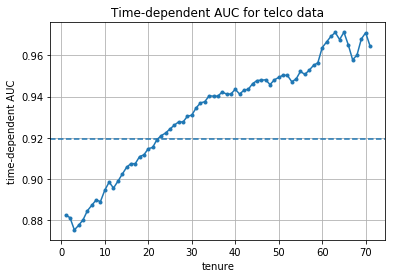

In [561]:
Cox_net_pred = Cox_net_best.predict(X_test)

times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, Cox_net_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [562]:
print(mean_auc)

0.9194202605729769


##  Univariate feature selection using SelectKBest  

In [563]:
# evaluate  the importance of each variables individually
# no need to standardize data 
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_train.values,data_y)
pd.Series(scores, index=data_x_unique.columns).sort_values(ascending=False)

Contract=Two year                        0.656067
PaymentMethod=Electronic check           0.653718
Partner=Yes                              0.632990
InternetService=Fiber optic              0.613661
TechSupport=Yes                          0.611807
OnlineSecurity=Yes                       0.611293
Contract=One year                        0.606976
DeviceProtection=Yes                     0.596107
OnlineBackup=Yes                         0.593613
Dependents=Yes                           0.583578
PaymentMethod=Credit card (automatic)    0.579898
InternetService=No                       0.571019
PaperlessBilling=Yes                     0.570400
MultipleLines=Yes                        0.549262
StreamingMovies=Yes                      0.538568
SeniorCitizen=1                          0.537410
StreamingTV=Yes                          0.537146
gender=Male                              0.513109
MonthlyCharges                           0.511820
PaymentMethod=Mailed check               0.504086


In [564]:
pipe_kbest = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [565]:
param_grid = {'select__k': np.arange(1, X_train.shape[1] + 1)}
gcv = GridSearchCV(pipe_kbest, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(X_train,data_y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('select',
                                        SelectKBest(k=3,
                                                    score_func=<function fit_and_score_features at 0x1a5a288c80>)),
                                       ('model',
                                        CoxPHSurvivalAnalysis(alpha=0,
                                                              n_iter=100,
                                                              ties='breslow',
                                                              tol=1e-09,
                                                              verbose=0))],
                                verbose=False),
             iid=True, n_jobs=None,
             param_grid={'select__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])},
             pre_dispatch='2*n_jobs', refit=True

In [566]:
pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,9.874192,0.031865,0.865848,0.868043,20,{'select__k': 20},1,0.872792,0.864995,0.870976,0.865009,0.853768,0.874124,0.172185,0.002534,0.008571,0.004300
20,9.839139,0.032808,0.865687,0.867988,21,{'select__k': 21},2,0.873029,0.864882,0.870430,0.865016,0.853594,0.874067,0.076077,0.003495,0.008614,0.004299
18,9.919472,0.033293,0.864585,0.866473,19,{'select__k': 19},3,0.871188,0.862757,0.871061,0.864978,0.851498,0.871685,0.143633,0.002988,0.009252,0.003795
17,9.963612,0.035348,0.863596,0.865637,18,{'select__k': 18},4,0.871130,0.862657,0.868145,0.862685,0.851507,0.871570,0.114704,0.001927,0.008633,0.004195
15,9.990378,0.031461,0.863549,0.865230,16,{'select__k': 16},5,0.872201,0.861801,0.867332,0.862791,0.851107,0.871099,0.093179,0.002342,0.009017,0.004170
16,9.859708,0.032659,0.863478,0.865388,17,{'select__k': 17},6,0.871788,0.862027,0.867288,0.862781,0.851352,0.871357,0.181489,0.000606,0.008767,0.004232
14,9.968172,0.033473,0.863016,0.864665,15,{'select__k': 15},7,0.872003,0.861707,0.866261,0.862501,0.850776,0.869786,0.100143,0.003967,0.008964,0.003636
13,9.890049,0.033838,0.862263,0.863974,14,{'select__k': 14},8,0.870747,0.860664,0.865539,0.861583,0.850496,0.869675,0.120920,0.003854,0.008586,0.004049
12,10.010505,0.032851,0.856542,0.858672,13,{'select__k': 13},9,0.865256,0.855508,0.858488,0.857032,0.845876,0.863477,0.167410,0.003249,0.008030,0.003454
11,9.901080,0.031546,0.854260,0.857051,12,{'select__k': 12},10,0.862813,0.852644,0.857298,0.857501,0.842662,0.861008,0.037525,0.002217,0.008502,0.003429


In [568]:
gcv.best_params_

{'select__k': 20}

In [569]:
gcv.score(X_train,data_y)

0.8676333288514462

In [570]:
gcv.score(X_test,data_y_test)

0.8581059513017275

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

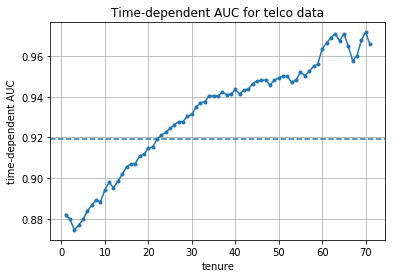

In [572]:
kbest_pred = gcv.predict(X_test)

times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, kbest_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [573]:
print(mean_auc)

0.9190580734714493


In [462]:
## which featreues to remove.
data_x_unique.columns[~pipe_best.steps[0][1].get_support()]

Index(['PhoneService=Yes', 'PaymentMethod=Mailed check'], dtype='object')

In [463]:
pd.Series(pipe_best.steps[1][1].coef_, index=data_x_unique.columns[pipe_best.steps[0][1].get_support()])

gender=Male                             -0.036250
SeniorCitizen=1                         -0.027994
Partner=Yes                             -0.262272
Dependents=Yes                          -0.025146
MultipleLines=No phone service          -0.099200
MultipleLines=Yes                       -0.202231
InternetService=Fiber optic              0.287052
InternetService=No                      -0.519845
OnlineSecurity=Yes                      -0.263858
OnlineBackup=Yes                        -0.284806
DeviceProtection=Yes                    -0.126964
TechSupport=Yes                         -0.157416
StreamingTV=Yes                          0.033181
StreamingMovies=Yes                     -0.016681
Contract=One year                       -0.665015
Contract=Two year                       -1.406854
PaperlessBilling=Yes                     0.081429
PaymentMethod=Credit card (automatic)   -0.134227
PaymentMethod=Electronic check           0.154314
MonthlyCharges                          -0.302281


## Survival Tree

In [317]:
tree = SurvivalTree(max_depth=8)

In [318]:
tree.fit(X_train,data_y)

SurvivalTree(max_depth=8, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=6,
             min_weight_fraction_leaf=0.0, presort='deprecated',
             random_state=None, splitter='best')

In [315]:
tree.score(X_train,data_y)

0.8581842708035812

In [316]:
tree.score(X_test,data_y_test)

0.8347071409418988

In [326]:
training_score = []
test_score = []

for i in range(X_train.shape[1]):
    tree = SurvivalTree(max_depth=i+1)
    tree.fit(X_train,data_y)
    training_score.append(tree.score(X_train,data_y))
    test_score.append(tree.score(X_test,data_y_test))

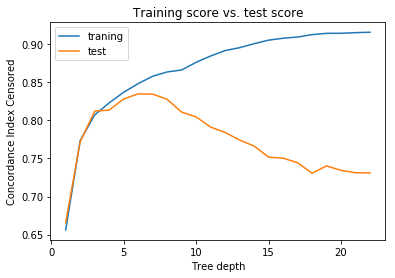

In [350]:
plt1 = plt.plot(np.arange(X_train.shape[1])+1,training_score)
plt2 = plt.plot(np.arange(X_train.shape[1])+1,test_score)
plt.xlabel('Tree depth')
plt.ylabel('Concordance Index Censored')
plt.title('Training score vs. test score')
plt.legend(['traning','test'])

In [358]:
# optimal tree depth is 6, the score is 0.8350
np.argmax(test_score), np.max(test_score)

(5, 0.8350217881813025)

In [389]:
tree = SurvivalTree(max_depth=6)
tree.fit(X_train,data_y)
tree.score(X_train,data_y)


0.8484324864688112

In [390]:
tree.score(X_test,data_y_test)

0.8350509728527834

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

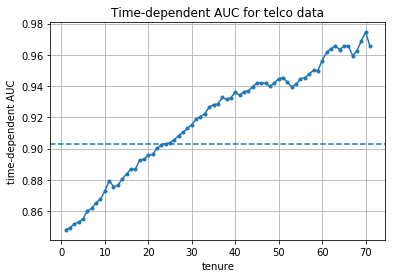

In [391]:
tree_pred = tree.predict(X_test)
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, tree_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [392]:
print(mean_auc)

0.9027309753920928


## Random Survival Forest

In [381]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)

In [382]:
rsf.fit(X_train,data_y)


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [383]:
#  Returns the concordance index of the prediction
rsf.score(X_test,data_y_test)

0.8375736228939156

In [384]:
#  Returns the concordance index of the prediction
rsf.score(X_train,data_y)

0.865851480335521

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

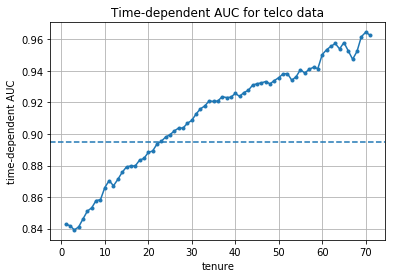

In [385]:
rsf_pred = rsf.predict(X_test)
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, rsf_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [387]:
print(mean_auc)

0.8951498211682009


## Gradient Boosting Survival Analysis

In [589]:
pipe_gb = Pipeline([('scale', StandardScaler()),('model', GradientBoostingSurvivalAnalysis())])
pipe_gb.fit(X_train,data_y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 GradientBoostingSurvivalAnalysis(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  dropout_rate=0.0,
                                                  learning_rate=0.1,
                                                  loss='coxph', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_f

In [590]:
pipe_gb.score(X_train,data_y)

0.8593859270863251

In [591]:
pipe_gb.score(X_test,data_y_test)

0.8473605200708458

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

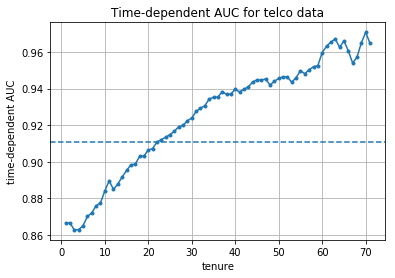

In [592]:
Gb_pred = pipe_gb.predict(X_test)
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, Gb_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [593]:
print(mean_auc)

0.9106275222819431


## Survival Support Vector Machine

In [602]:
pipe_svm = Pipeline([('scale', StandardScaler()),('model', FastSurvivalSVM())])
pipe_svm.fit(X_train,data_y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 FastSurvivalSVM(alpha=1, fit_intercept=False, max_iter=20,
                                 optimizer='avltree', random_state=None,
                                 rank_ratio=1.0, timeit=False, tol=None,
                                 verbose=False))],
         verbose=False)

In [603]:
pipe_svm.score(X_train,data_y)

0.870482973734815

In [604]:
pipe_svm.score(X_test,data_y_test)

0.8624143384290985

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

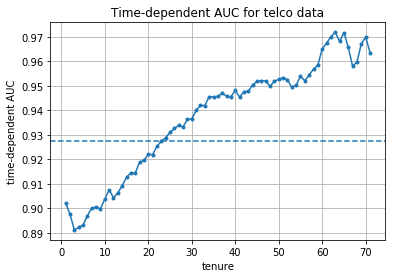

In [605]:
svm_pred = pipe_svm.predict(X_test)
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, svm_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [606]:
print(mean_auc)

0.9274090787960534


## Survival Kernel Support Vector Machine

In [610]:
pipe_ksvm = Pipeline([('scale', StandardScaler()),('model', FastKernelSurvivalSVM(kernel='rbf'))])
pipe_ksvm.fit(X_train,data_y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 FastKernelSurvivalSVM(alpha=1, coef0=1, degree=3,
                                       fit_intercept=False, gamma=None,
                                       kernel='rbf', kernel_params=None,
                                       max_iter=20, optimizer='rbtree',
                                       random_state=None, rank_ratio=1.0,
                                       timeit=False, tol=None,
                                       verbose=False))],
         verbose=False)

In [611]:
pipe_ksvm.score(X_train,data_y)

0.9098797568006008

In [612]:
pipe_ksvm.score(X_test,data_y_test)

0.8442122236348414

Text(0.5, 1.0, 'Time-dependent AUC for telco data')

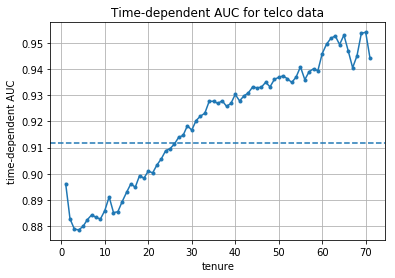

In [617]:
ksvm_pred = pipe_ksvm.predict(X_test)
times = range(1,int(data_y_test['tenure'].max()))
auc, mean_auc = cumulative_dynamic_auc(data_y, data_y_test, ksvm_pred, times)
plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [618]:
print(mean_auc)

0.9117187997197347
